In [1]:
import os
os.chdir('../../')


In [31]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import sin_data
from models import gaussian_mlp,mlp
from utilities import plot,fits,predict,gmm
from flax import linen as nn

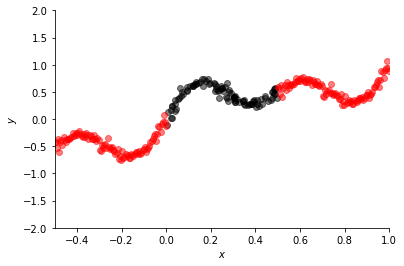

In [3]:
X,Y,x_test_1,y_test_1,x_test_2,y_test_2 = sin_data.load_data()
plot.plot_actualdata(X,Y,x_test_1,y_test_1,x_test_2,y_test_2)

In [30]:
auxs = {
    "X" : X,
    "y" : Y,
    "deterministic": True,
}
X_sorted  = jnp.sort(X[:,0]).reshape(100,1)
Y_sorted  = jnp.sort(Y)
x_stack =jnp.concatenate([x_test_1,X_sorted,x_test_2],axis=0)
y_stack = jnp.concatenate([y_test_1,Y,y_test_2],axis=0)

## MLP

In [43]:
model = mlp.mlp([16,16,1],[nn.relu,nn.relu],[0,0])

In [44]:
model.tabulate(jax.random.PRNGKey(1), X, deterministic=True)

                          mlp Summary                           
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path        ┃ outputs               ┃ params                 ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs      │ - float32[100,1]      │                        │
│             │ - deterministic: True │                        │
├─────────────┼───────────────────────┼────────────────────────┤
│ 0_Dense     │ float32[100,16]       │ bias: float32[16]      │
│             │                       │ kernel: float32[1,16]  │
│             │                       │                        │
│             │                       │ 32 (128 B)             │
├─────────────┼───────────────────────┼────────────────────────┤
│ 0_Dropout_0 │ float32[100,16]       │                        │
├─────────────┼───────────────────────┼────────────────────────┤
│ 1_Dense     │ float32[100,16]       │ bias: float32[16]      │
│             │                       │ kernel: float32[16,16] │
│             │                       │                        │
│             │                       │ 272 (1.1 KB)           │
├─────────────┼───────────────────────┼────────────────────────┤
│ 1_Dropout_0 │ float32[100,16]       │                        │
├─────────────┼───────────────────────┼────────────────────────┤
│ 2_Dense     │ float32[100,1]        │ bias: float32[1]       │
│             │                       │ kernel: float32[16,1]  │
│             │                       │                        │
│             │                       │ 17 (68 B)              │
├─────────────┼───────────────────────┼────────────────────────┤
│ mlp         │ float32[100,1]        │                        │
├─────────────┼───────────────────────┼────────────────────────┤
│             │                 Total │ 321 (1.3 KB)           │
└─────────────┴───────────────────────┴────────────────────────┘
                                                                
                 Total Parameters: 321 (1.3 KB)                 

'\n\n'

In [45]:
seed=11
params = model.init(jax.random.PRNGKey(seed), X, deterministic = True)
params, loss =  fits.fit(model, params, auxs, learning_rate=0.003, epochs=2000, verbose=False)


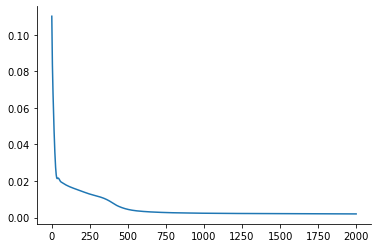

In [46]:
plt.plot(jnp.arange(0,2000,1),loss)
sns.despine()

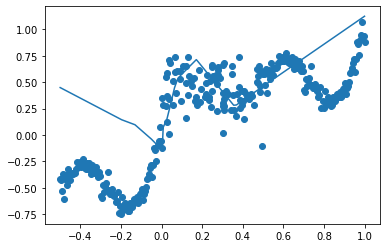

In [52]:
y_hat = model.apply(params,x_stack,deterministic=True)
plt.plot(x_stack,y_hat)
plt.scatter(x_stack,y_stack)

## Gaussian MLP

In [4]:
model = gaussian_mlp.gmlp( features=[16,16], activations=[nn.relu, nn.relu],dropout_rate=[0,0])

In [5]:
model.tabulate(jax.random.PRNGKey(1), X, deterministic=True)

                          gmlp Summary                          
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path        ┃ outputs               ┃ params                 ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs      │ - float32[100,1]      │                        │
│             │ - deterministic: True │                        │
├─────────────┼───────────────────────┼────────────────────────┤
│ 0_Dense     │ float32[100,16]       │ bias: float32[16]      │
│             │                       │ kernel: float32[1,16]  │
│             │                       │                        │
│             │                       │ 32 (128 B)             │
├─────────────┼───────────────────────┼────────────────────────┤
│ 0_Dropout_0 │ float32[100,16]       │                        │
├─────────────┼───────────────────────┼────────────────────────┤
│ 1_Dense     │ float32[100,16]       │ bias: float32[16]      │
│             │                       │ kernel: float32[16,16] │
│             │                       │                        │
│             │                       │ 272 (1.1 KB)           │
├─────────────┼───────────────────────┼────────────────────────┤
│ 1_Dropout_0 │ float32[100,16]       │                        │
├─────────────┼───────────────────────┼────────────────────────┤
│ Gaussian    │ float32[100,2]        │ bias: float32[2]       │
│             │                       │ kernel: float32[16,2]  │
│             │                       │                        │
│             │                       │ 34 (136 B)             │
├─────────────┼───────────────────────┼────────────────────────┤
│ gmlp        │ - float32[100]        │                        │
│             │ - float32[100]        │                        │
├─────────────┼───────────────────────┼────────────────────────┤
│             │                 Total │ 338 (1.4 KB)           │
└─────────────┴───────────────────────┴────────────────────────┘
                                                                
                 Total Parameters: 338 (1.4 KB)                 

'\n\n'

### Single Gaussian MLP

In [28]:
seed=11
params = model.init(jax.random.PRNGKey(seed), X, deterministic = True)
params, loss =  fits.fit(model, params, auxs, learning_rate=0.003, epochs=2000, verbose=False)


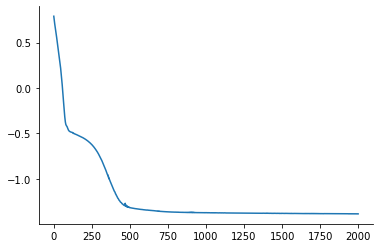

In [29]:
plt.plot(jnp.arange(0,2000,1),loss)
sns.despine()


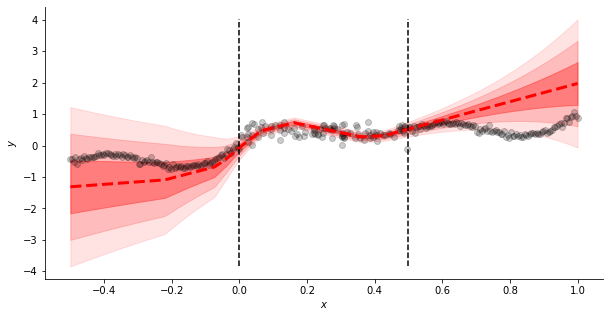

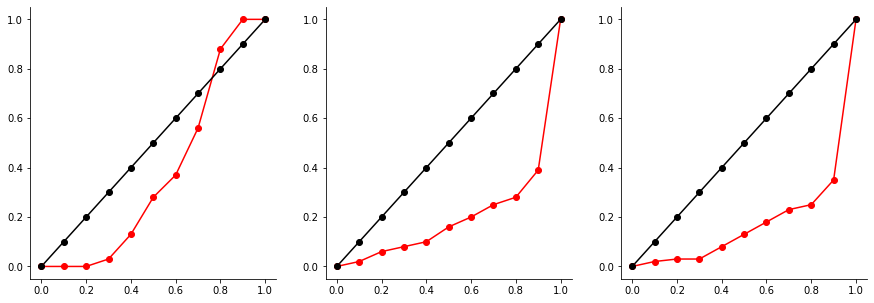

In [22]:
mean,sigma = model.apply(params,x_stack,deterministic=True)
plot.plot_prediction(x_stack,y_stack,mean,sigma)
fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
df,df2 = plot.calibration_regression(mean[:100],sigma[:100],y_test_1,ax1)
df = plot.calibration_regression(mean[100:200],sigma[100:200],Y,ax2)
df,_ = plot.calibration_regression(mean[200:],sigma[200:],y_test_2,ax3)


### Gaussian Deep Ensemble

In [23]:
params_list = []
losses_list = []

for i in range(5):
    params = model.init(jax.random.PRNGKey(i), auxs['X'], deterministic = True)
    params, loss =  fits.fit(model, params, auxs, learning_rate=0.003, epochs=2000, verbose=False)
    params_list.append(params)
    losses_list.append(loss)



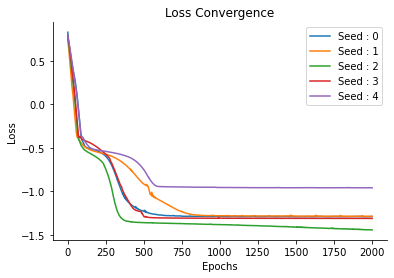

In [24]:
for i in range(5):
    plt.plot(jnp.arange(0,2000,1),losses_list[i],label=f'Seed : {i}')
plt.legend()
plt.title('Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
sns.despine()

In [25]:
means_list,sigmas_list = predict.predict(5,model,params_list,x_stack)
mean,sigma = gmm.gmm_mean_var(means_list,sigmas_list)


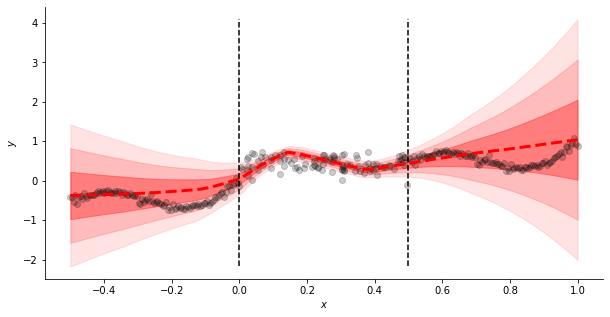

In [26]:
plot.plot_prediction(x_stack,y_stack,mean,sigma)

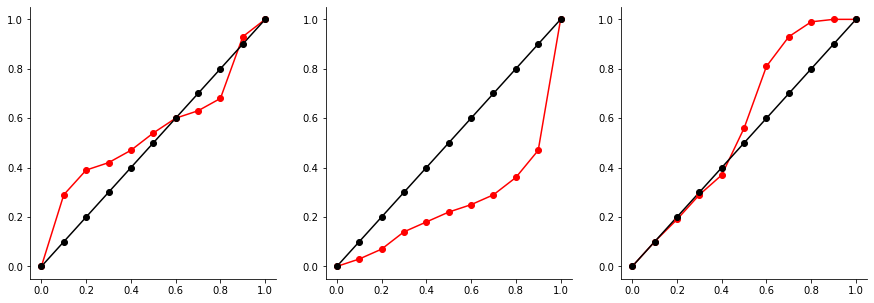

In [27]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
df = plot.calibration_regression(mean[:100],sigma[:100],y_test_1,ax1)
df = plot.calibration_regression(mean[100:200],sigma[100:200],Y_sorted,ax2)
df = plot.calibration_regression(mean[200:],sigma[200:],y_test_2,ax3)
